<a href="https://colab.research.google.com/github/Arbin4/DM_DW_LAB/blob/main/Lab_I_DW_DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def fetch_stock_history(symbol, start_date, end_date):
    url = (
        f"https://www.nepalipaisa.com/api/GetStockHistory"
        f"?stockSymbol={symbol}&fromDate={start_date}&toDate={end_date}"
        f"&pageNo=1&itemsPerPage=50&pagePerDisplay=5"
    )
    response = requests.get(url)
    if response.status_code == 200:
        json_data = response.json()
        data = json_data.get("result", {}).get("data", [])
        if not data:
            print(f"No data for symbol {symbol}")
            return pd.DataFrame()
        df = pd.DataFrame(data)
        df["Symbol"] = symbol
        return df
    else:
        print(f"Failed to fetch data for {symbol}")
        return pd.DataFrame()

In [3]:
symbols = ['ADBL', 'CZBIL', 'EBL', 'GBIME', 'HBL', 'KBL', 'MBL', 'NABIL', 'NBL', 'NICA']
dfs = {}
for sym in symbols:
    url = (
        "https://www.nepalipaisa.com/api/GetStockHistory"
        f"?stockSymbol={sym}&fromDate=2025-04-19&toDate=2025-05-19"
        "&pageNo=1&itemsPerPage=100&pagePerDisplay=5"
    )

    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error fetching data for {sym}")
        continue

    raw_data = response.json().get("result", {}).get("data", [])
    if not isinstance(raw_data, list) or len(raw_data) == 0:
        print(f"No data for {sym}")
        continue

    # Normalize and clean
    df = pd.DataFrame(raw_data)
    df = df.rename(columns={
        "tradeDate": "Date",
        "closingPrice": "Close",
        "maxPrice": "High",
        "minPrice": "Low",
        "volume": "Volume"
    })

    # Parse and clean
    df["Date"] = pd.to_datetime(df["Date"])
    numeric_cols = ["High", "Low", "Close", "Volume"]
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    df = df[["Date", "High", "Low", "Close", "Volume"]].sort_values("Date").dropna()

    dfs[sym] = df
    df.to_csv(f"{sym}_daily.csv", index=False)
    print(f"Saved {sym} with {len(df)} rows.")

Saved ADBL with 20 rows.
Saved CZBIL with 20 rows.
Saved EBL with 20 rows.
Saved GBIME with 20 rows.
Saved HBL with 20 rows.
Saved KBL with 20 rows.
Saved MBL with 20 rows.
Saved NABIL with 20 rows.
Saved NBL with 20 rows.
Saved NICA with 20 rows.


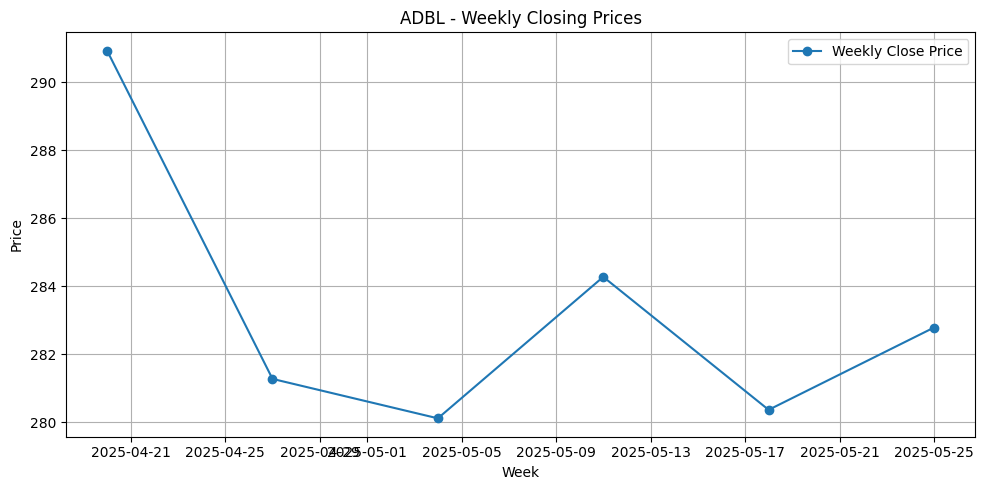

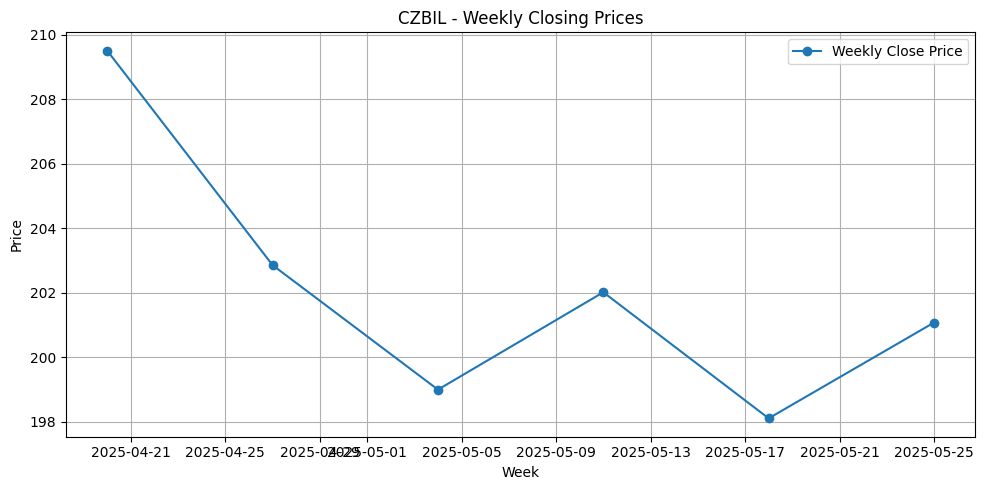

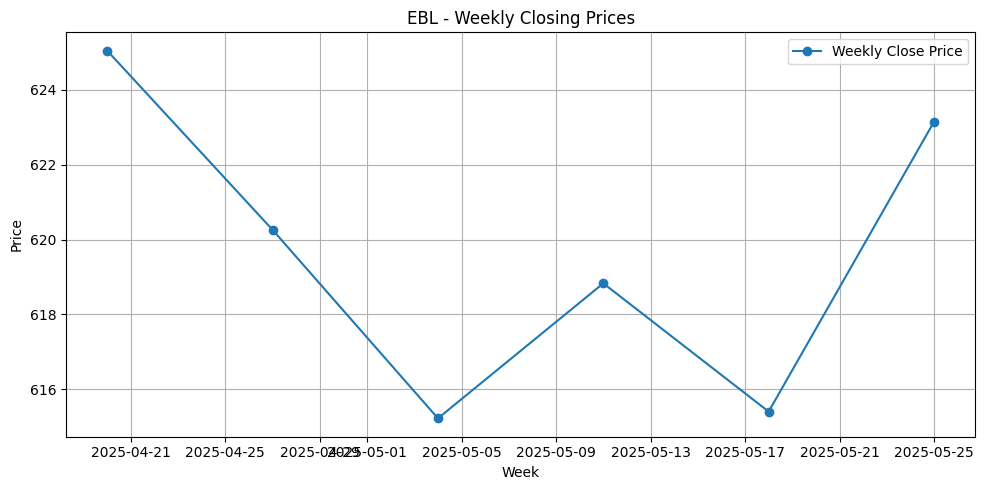

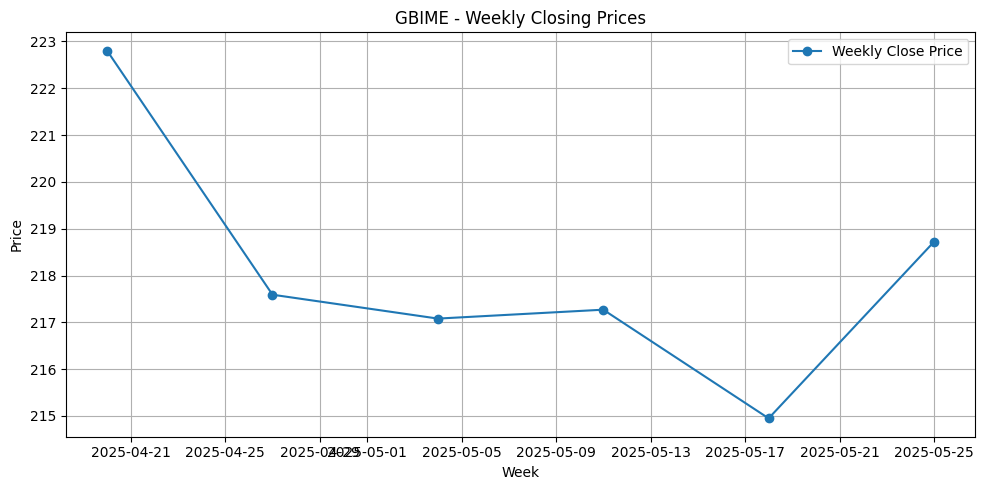

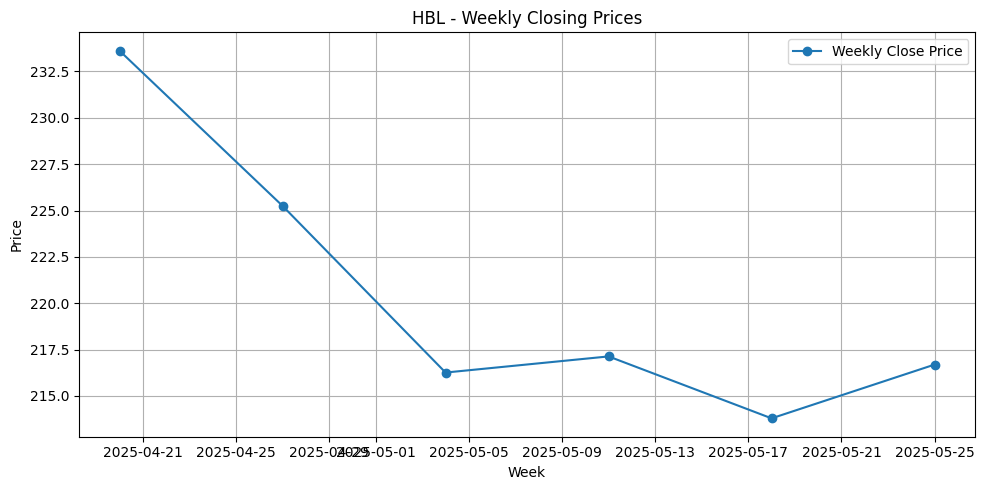

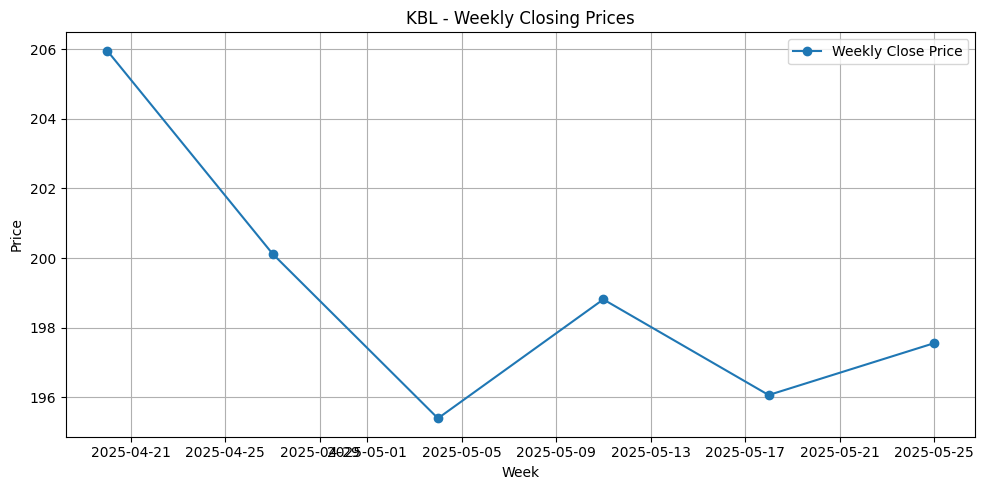

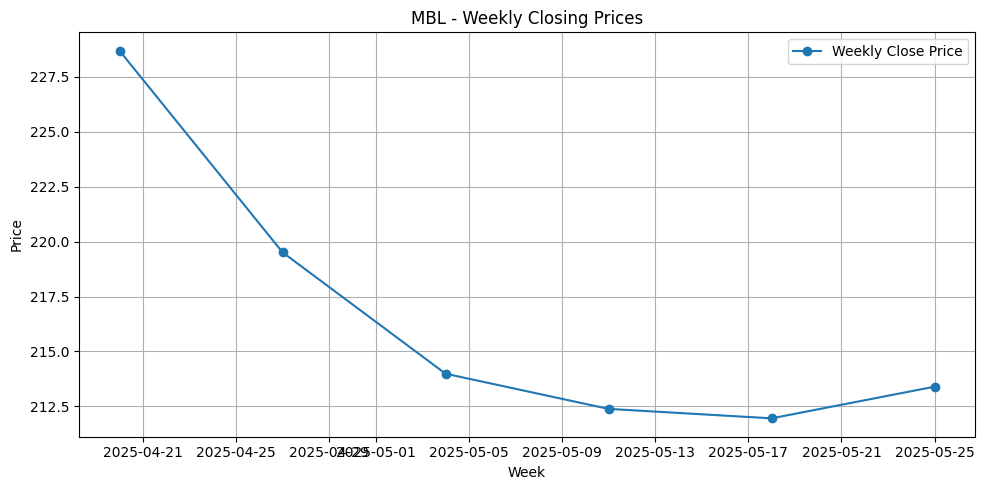

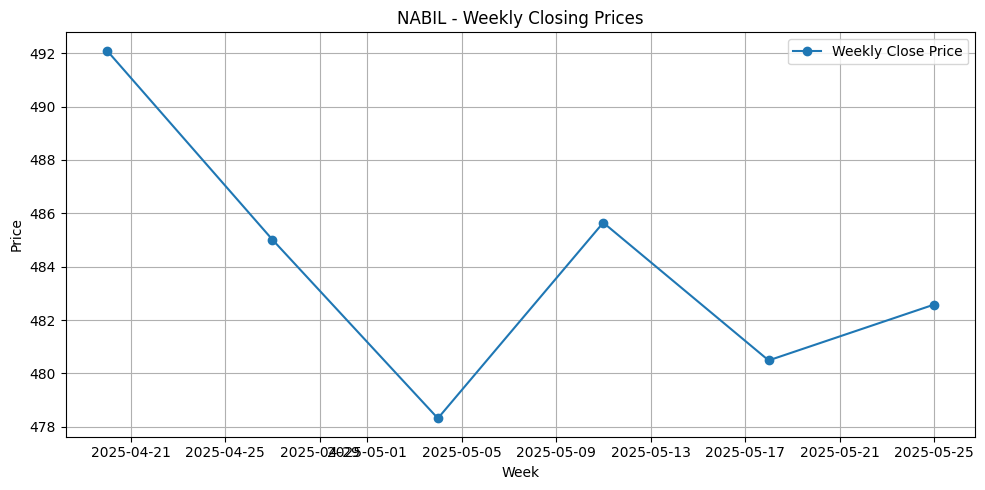

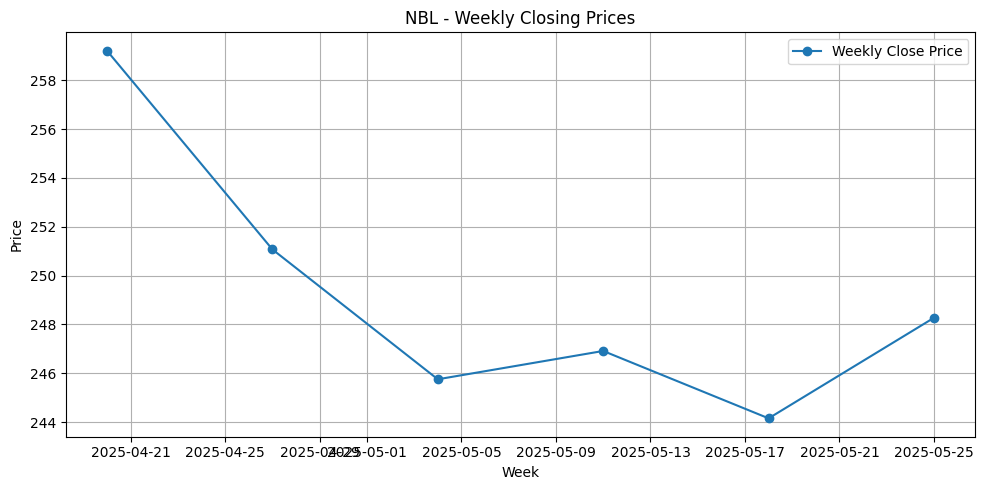

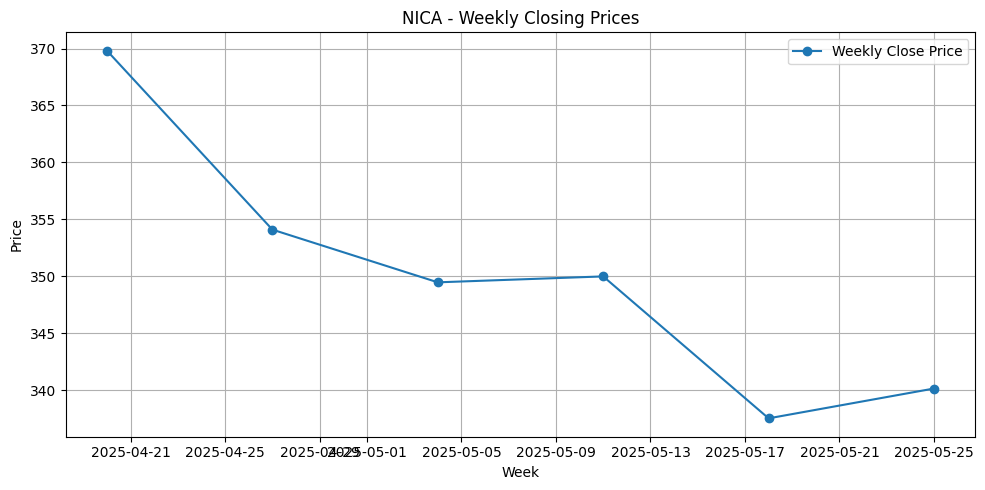

In [4]:
for sym in symbols:
    file = f"{sym}_daily.csv"
    if not os.path.exists(file):
        print(f"{file} not found.")
        continue

    df = pd.read_csv(file, parse_dates=["Date"])
    df.set_index("Date", inplace=True)

    # Resample to weekly data
    weekly = df.resample("W").agg({
        "High": "max",
        "Low": "min",
        "Close": "last",
        "Volume": "sum"
    }).dropna()

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(weekly.index, weekly["Close"], marker="o", label="Weekly Close Price")
    plt.title(f"{sym} - Weekly Closing Prices")
    plt.xlabel("Week")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [5]:
def calculate_indicators(df):
    df = df.copy()

    # SMA (Simple Moving Average)
    df['SMA_14'] = df['Close'].rolling(window=14).mean()

    # WMA (Weighted Moving Average)
    weights = np.arange(1, 15)
    df['WMA_14'] = df['Close'].rolling(window=14).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)

    # RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    # OBV (On-Balance Volume)
    obv = [0]
    for i in range(1, len(df)):
        if df['Close'].iloc[i] > df['Close'].iloc[i - 1]:
            obv.append(obv[-1] + df['Volume'].iloc[i])
        elif df['Close'].iloc[i] < df['Close'].iloc[i - 1]:
            obv.append(obv[-1] - df['Volume'].iloc[i])
        else:
            obv.append(obv[-1])
    df['OBV'] = obv

    # CCI (Commodity Channel Index)
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    ma = tp.rolling(14).mean()
    md = tp.rolling(14).apply(lambda x: np.mean(np.abs(x - np.mean(x))))
    df['CCI_14'] = (tp - ma) / (0.015 * md)

    return df

In [6]:
# Plotting function
def plot_indicators(df, symbol):
    df.set_index('Date', inplace=True)

    plt.figure(figsize=(14, 10))

    # Plot Close with SMA and WMA
    plt.subplot(3, 1, 1)
    plt.plot(df.index, df['Close'], label='Close')
    plt.plot(df.index, df['SMA_14'], label='SMA 14')
    plt.plot(df.index, df['WMA_14'], label='WMA 14')
    plt.title(f"{symbol} - Price & Averages")
    plt.legend()
    plt.grid()

    # Plot RSI
    plt.subplot(3, 1, 2)
    plt.plot(df.index, df['RSI_14'], color='orange')
    plt.axhline(70, linestyle='--', color='red')
    plt.axhline(30, linestyle='--', color='green')
    plt.title(f"{symbol} - RSI (14)")
    plt.grid()

    # Plot OBV and CCI
    plt.subplot(3, 1, 3)
    plt.plot(df.index, df['OBV'], label='OBV', color='purple')
    plt.twinx().plot(df.index, df['CCI_14'], label='CCI', color='brown')
    plt.title(f"{symbol} - OBV and CCI")
    plt.grid()

    plt.tight_layout()
    plt.show()

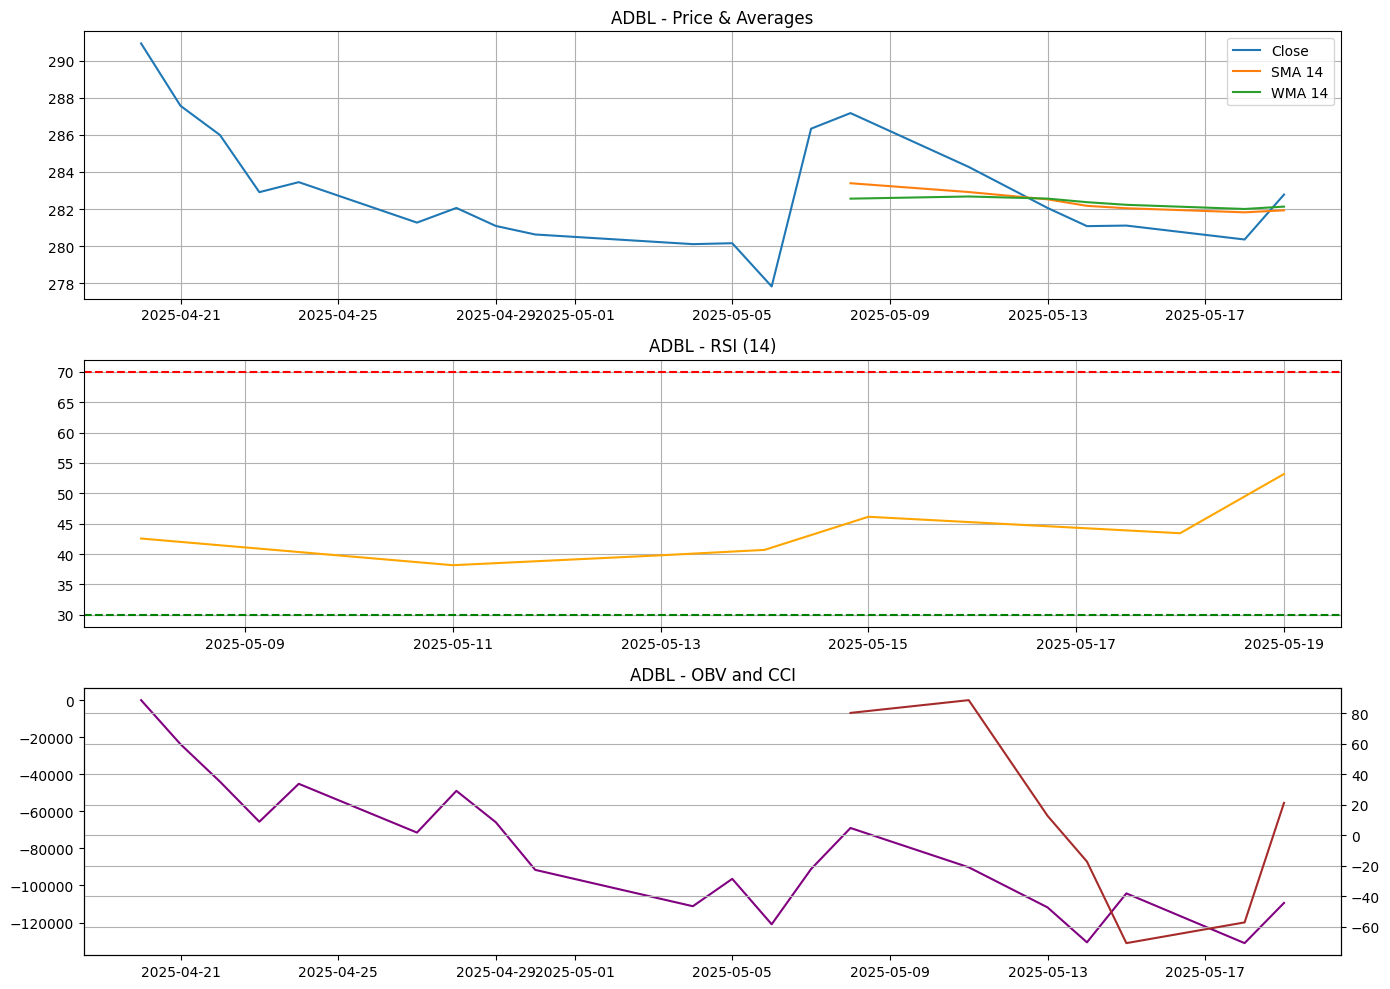

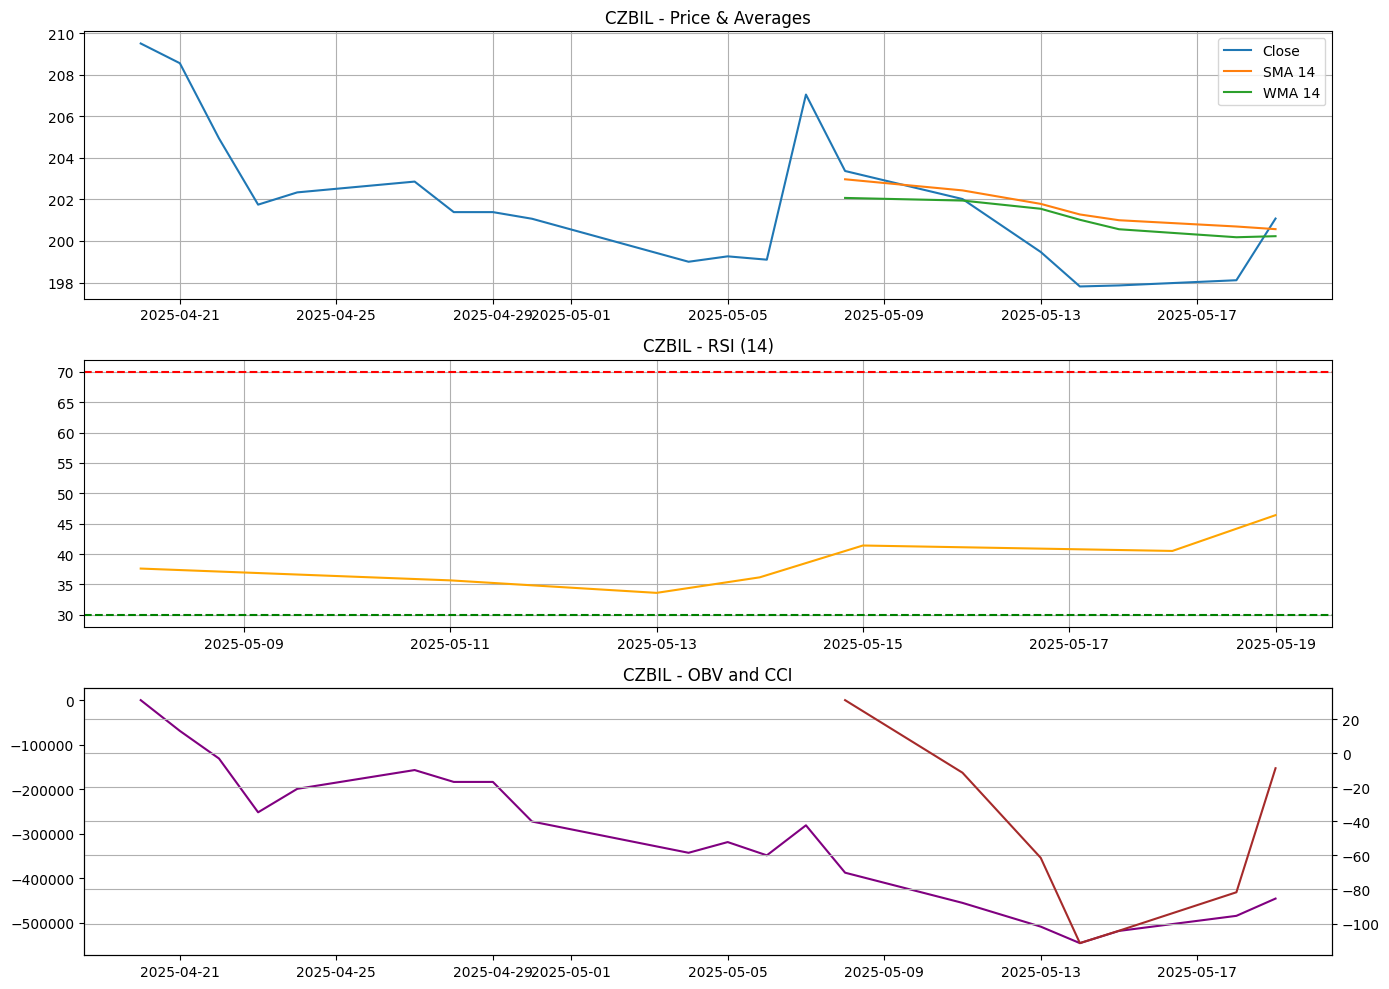

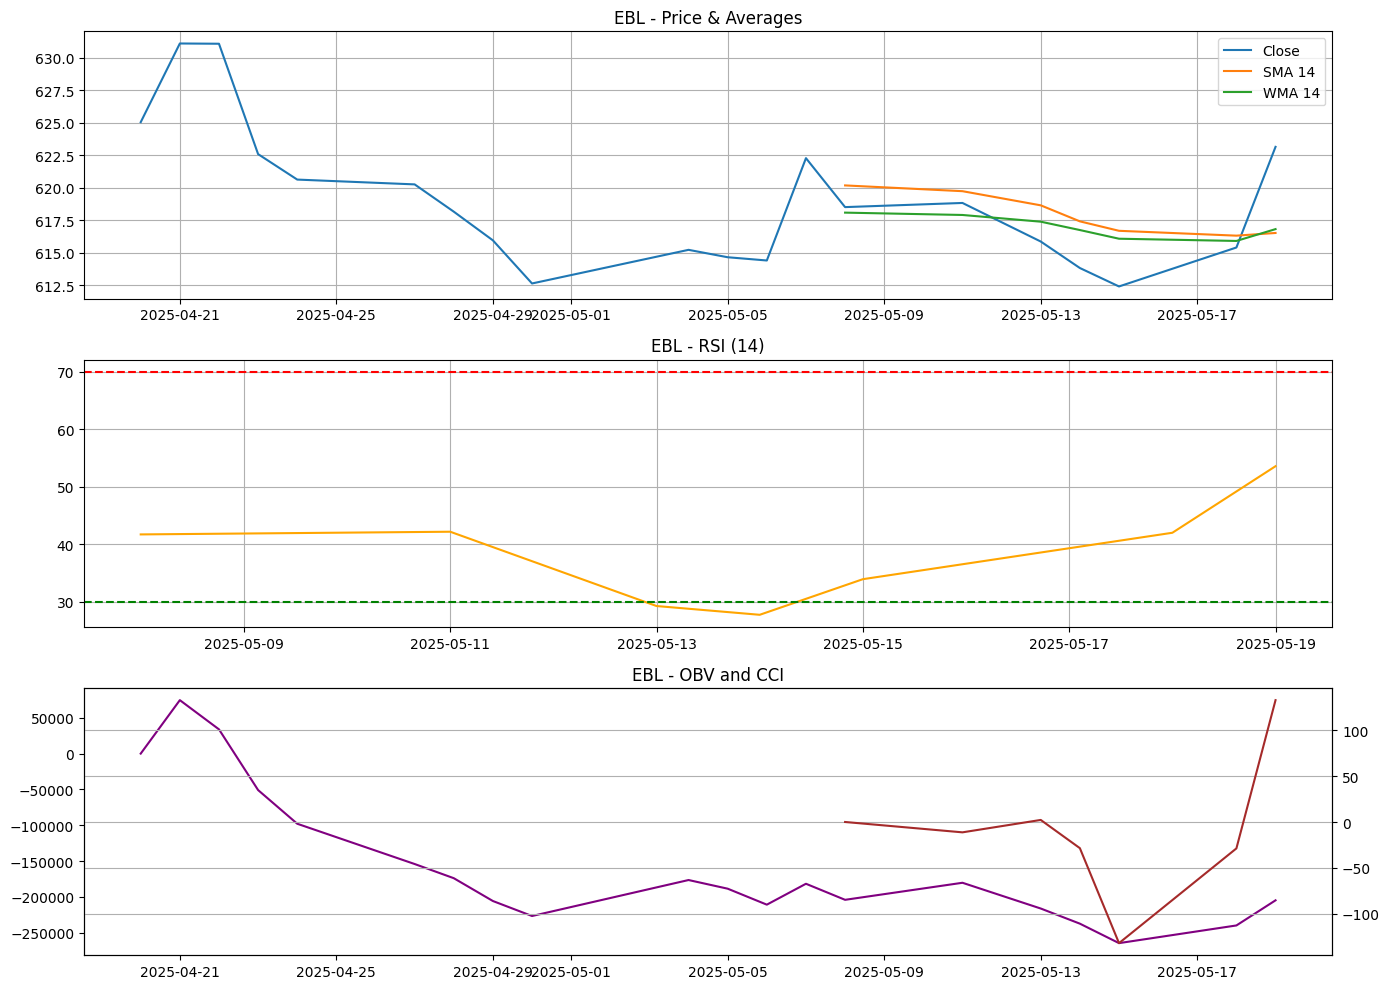

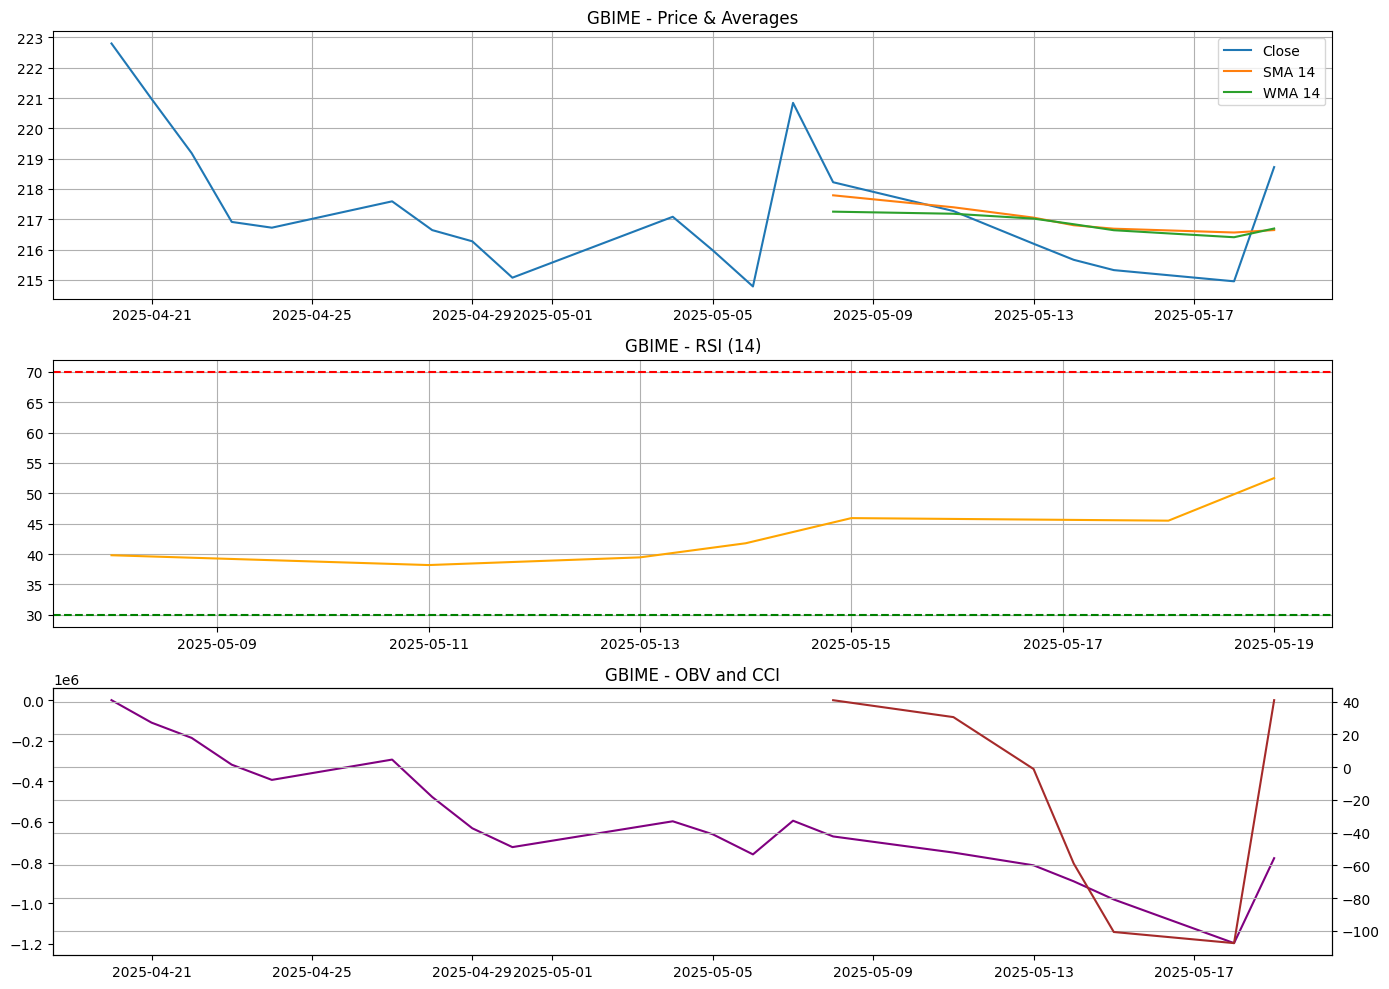

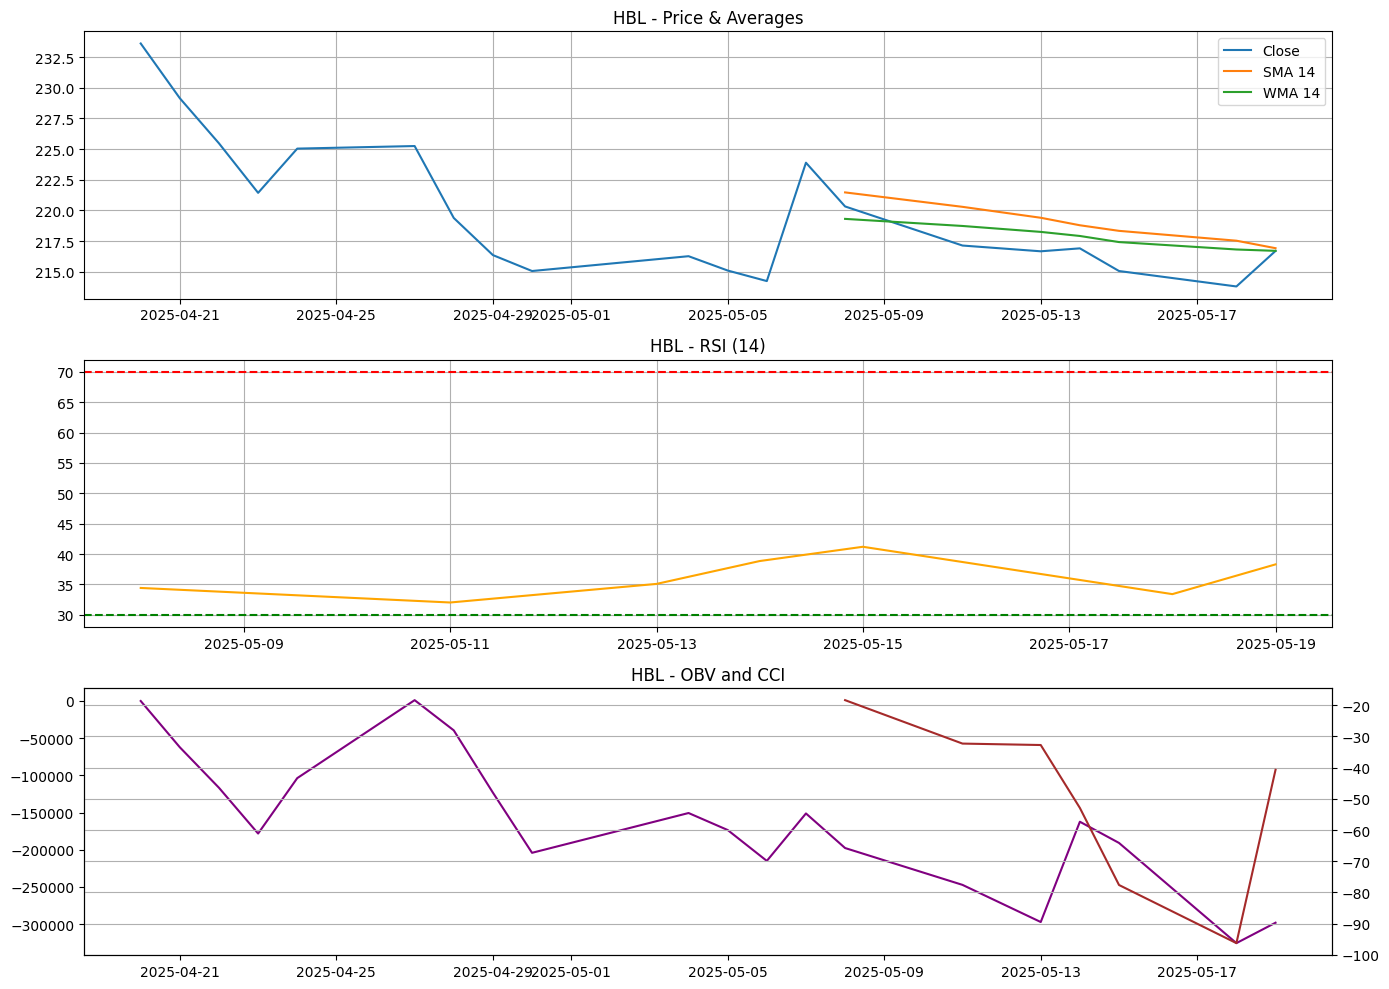

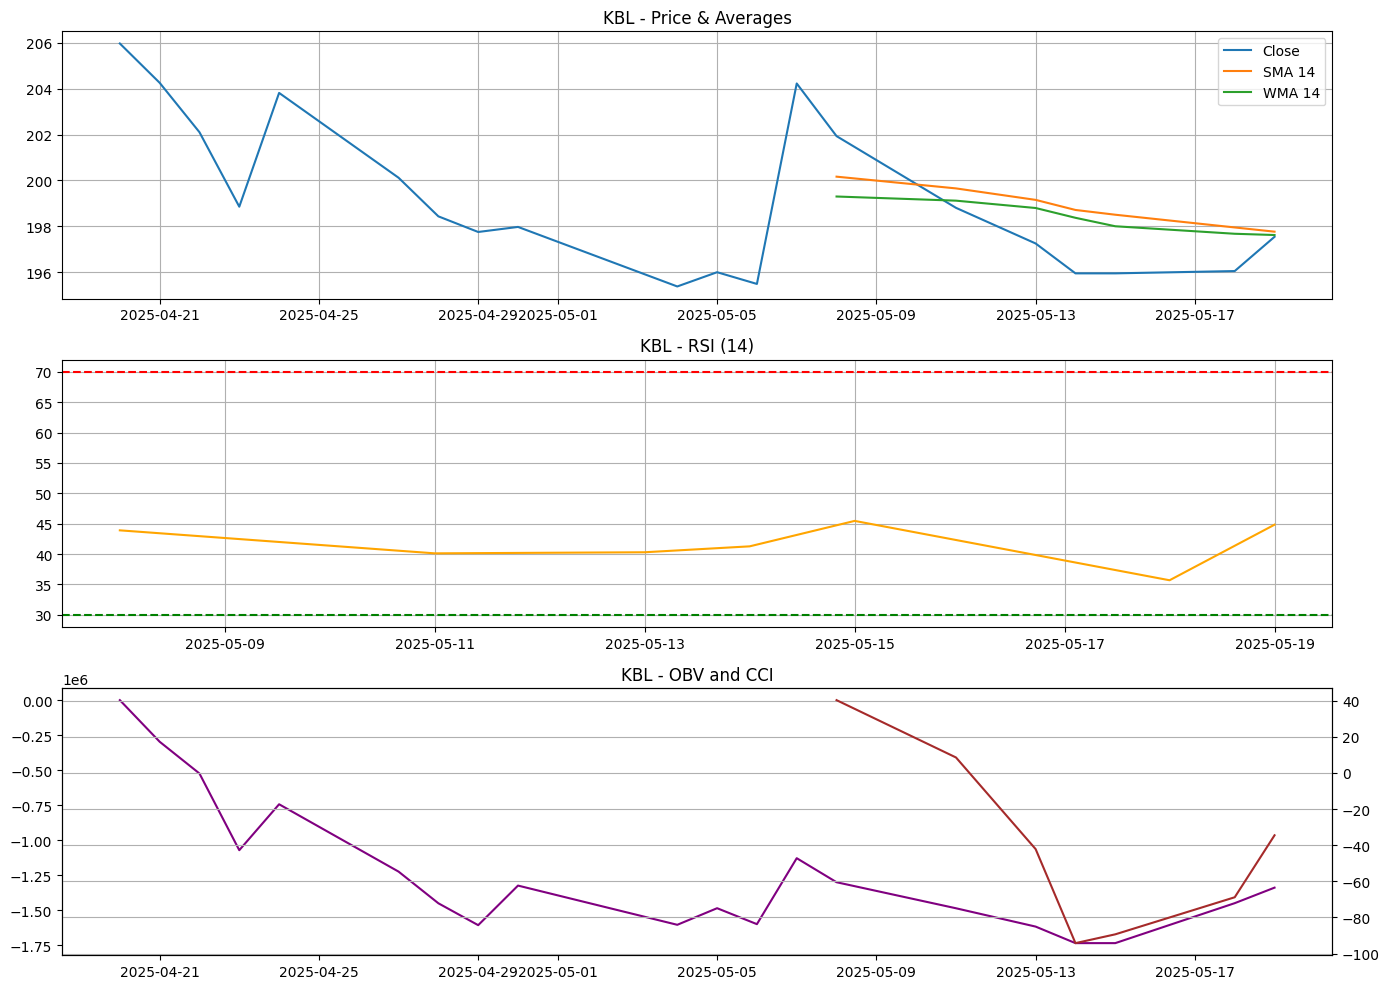

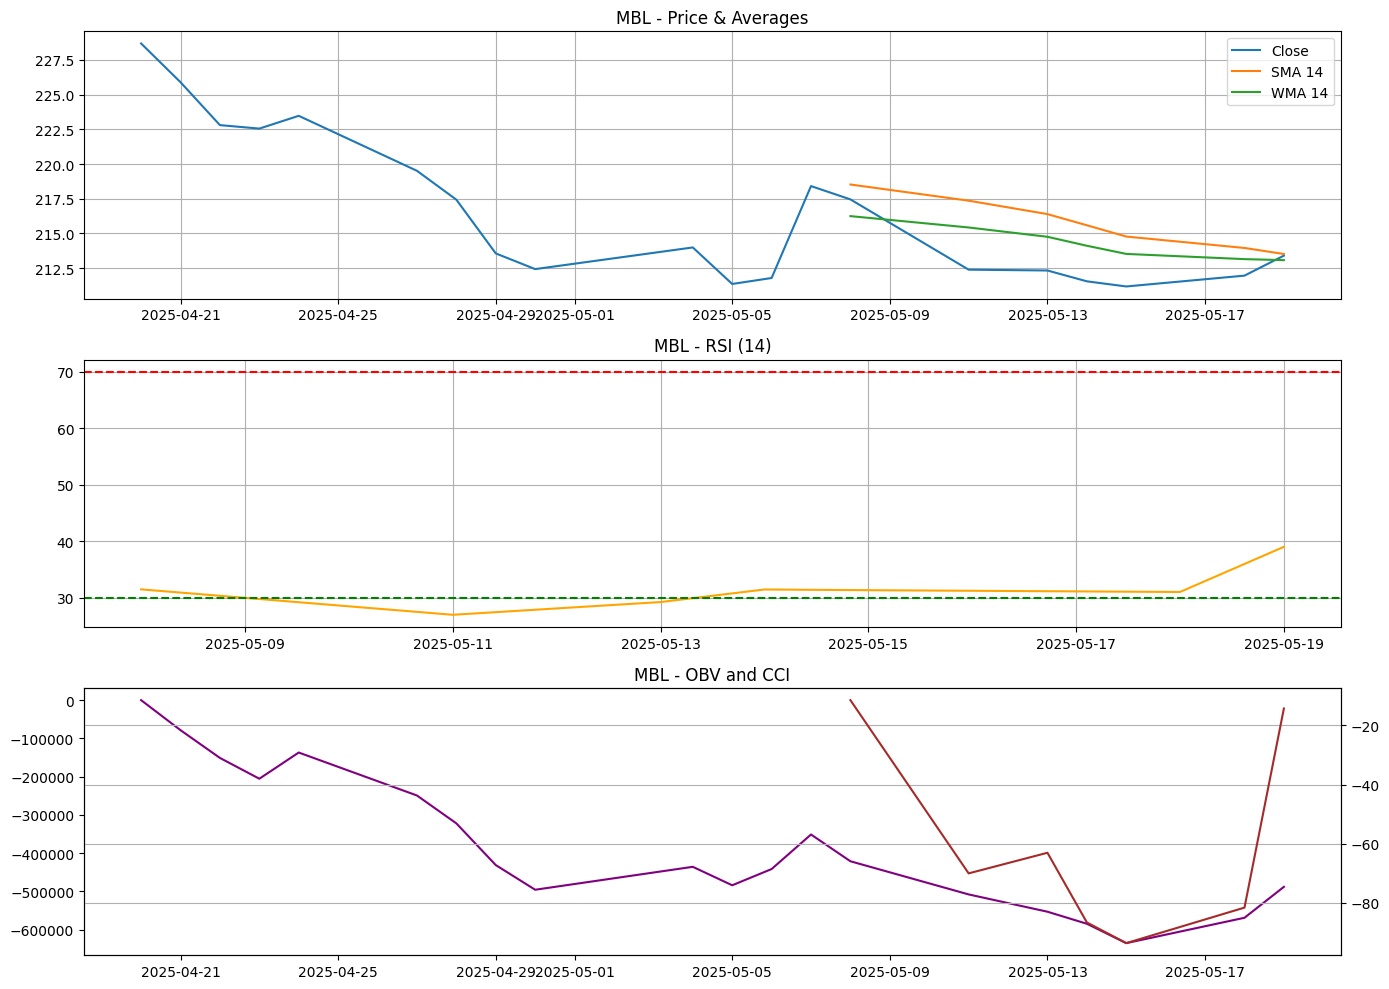

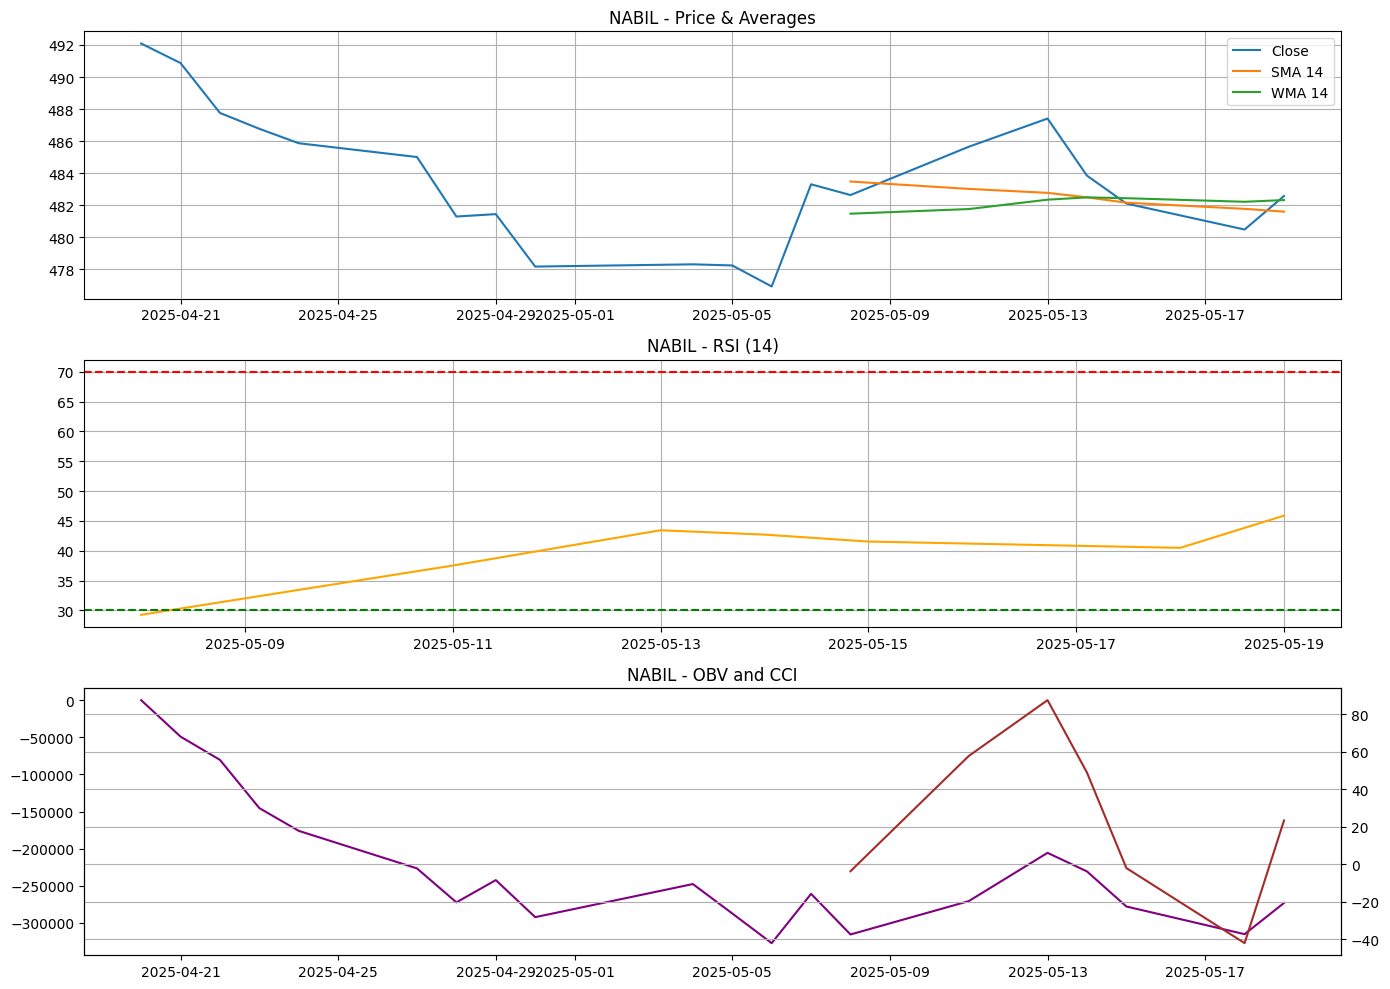

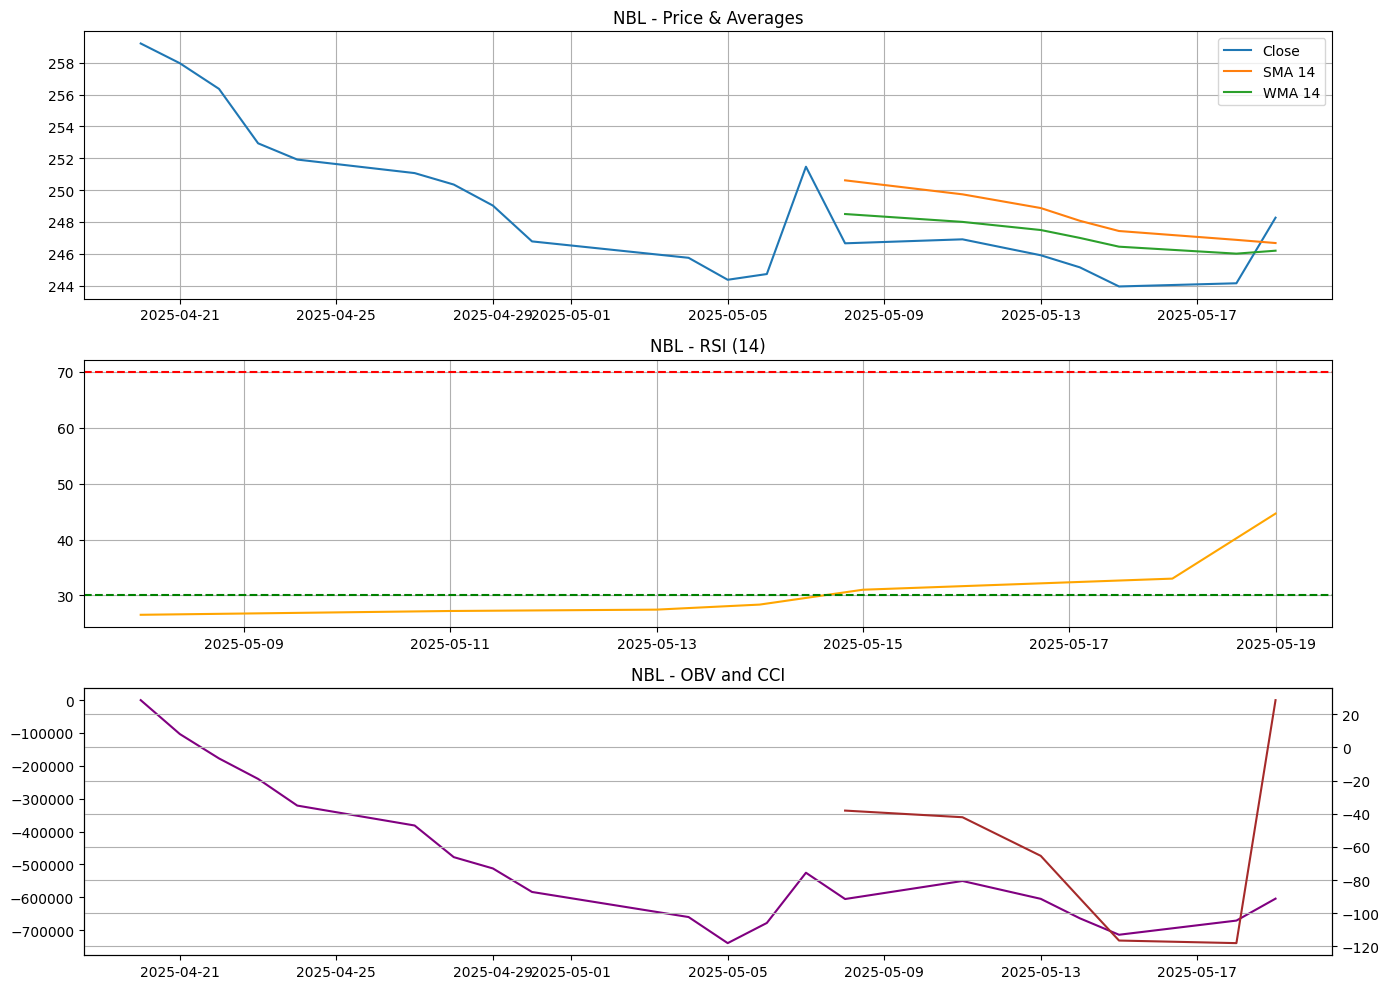

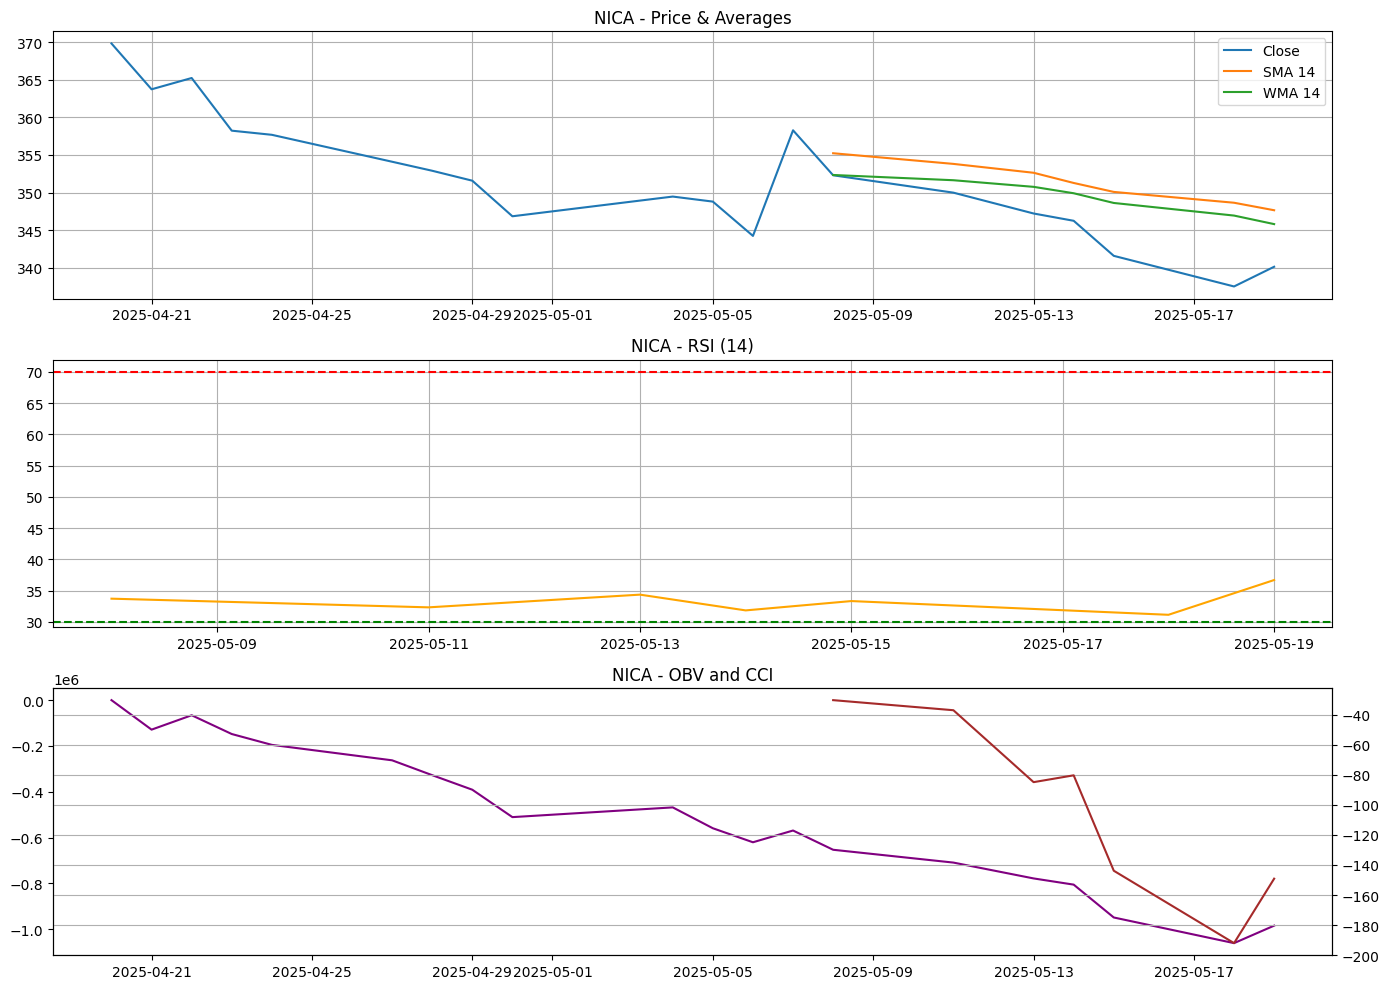

In [7]:
for sym in symbols:
    file = f"{sym}_daily.csv"
    if not os.path.exists(file):
        print(f"{file} not found.")
        continue

    df = pd.read_csv(file, parse_dates=["Date"])
    df = df.sort_values("Date")
    df = calculate_indicators(df)
    plot_indicators(df, sym)